In [1]:
import sys
sys.path.append("../") 

In [2]:
from __future__ import division

import argparse, time, logging, random, math

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

In [3]:
mx.__version__

'2.0.0beta1'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.,1.)
])

In [5]:
num_gpus = 0
model_ctx = mx.gpu()

num_workers = 0
batch_size = 256 
train_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=True).transform_first(transform),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=num_workers)

val_data = gluon.data.DataLoader(
    gluon.data.vision.MNIST(train=False).transform_first(transform),
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

[12:03:27] ../src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


In [6]:
for X,y in train_data:
    print(X.shape)
    print(y.shape)
    break

(256, 1, 28, 28)
(256,)


In [7]:
model_ctx

gpu(0)

In [8]:
type(X)

mxnet.numpy.ndarray

In [10]:
X.device

cpu(0)

### Bayesian inference for MNIST

* [Stochastic Gradient Descent](#chapter1)
* [Stochastic Gradient Langevin Dynamics](#chapter2)
* [Bayes By Backprop](#chapter3)
* [Diagnostics](#chapter4)


# Stochastic Gradient Descent <a class="anchor" id="chapter1"></a>

In [13]:
import mxnet as mx
from mxnet import nd, autograd, gluon
hyper={'alpha':10.}
in_units=(1,28,28)
out_units=10

In [15]:
!pip3 install h5py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 34.5 MB/s eta 0:00:00m eta 0:00:010:01


In [16]:
import mxnet as mx
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgd(model,step_size=0.01,ctx=model_ctx)

[12:05:56] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8202 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.
[12:05:59] ../src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU
[12:06:03] ../src/operator/cudnn_ops.cc:341: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable
[12:06:04] ../src/operator/cudnn_ops.cc:341: Auto-tuning cuDNN op, set MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable


In [17]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgd)
    print('modules re-loaded')
except:
    print('no modules loaded yet')


modules re-loaded


iteration 0, train loss: 2.0165, train accuracy : 0.5156
iteration 1, train loss: 0.3741, train accuracy : 0.7402
iteration 2, train loss: 0.1346, train accuracy : 0.8177
iteration 3, train loss: 0.0918, train accuracy : 0.8633
iteration 4, train loss: 0.0692, train accuracy : 0.8891
iteration 5, train loss: 0.0550, train accuracy : 0.9076
iteration 6, train loss: 0.0467, train accuracy : 0.9202
iteration 7, train loss: 0.0400, train accuracy : 0.9302
iteration 8, train loss: 0.0357, train accuracy : 0.9379
iteration 9, train loss: 0.0331, train accuracy : 0.9441
iteration 10, train loss: 0.0278, train accuracy : 0.9492
iteration 11, train loss: 0.0259, train accuracy : 0.9528
iteration 12, train loss: 0.0238, train accuracy : 0.9564
iteration 13, train loss: 0.0208, train accuracy : 0.9595
iteration 14, train loss: 0.0197, train accuracy : 0.9622
iteration 15, train loss: 0.0170, train accuracy : 0.9646
iteration 16, train loss: 0.0170, train accuracy : 0.9665
iteration 17, train loss

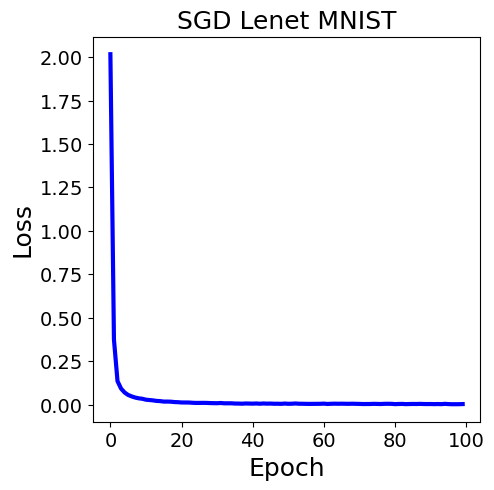

In [18]:
train_sgd=True
num_epochs=100
import h5py
import matplotlib.pyplot as plt

if train_sgd:
    par,loss=inference.fit(epochs=num_epochs,batch_size=batch_size,data_loader=train_data,
                           chain_name='lenet_map.h5',verbose=True)

    fig=plt.figure(figsize=[5,5])
    plt.plot(loss,color='blue',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgd_lenet.pdf', bbox_inches='tight')
else:
    map_estimate=h5py.File('lenet_map.h5','r')
    par={var:map_estimate[var][:] for var in map_estimate.keys()}
    map_estimate.close()
    

In [21]:
model.net.collect_params()

{'0.weight': Parameter (shape=(6, 1, 5, 5), dtype=<class 'numpy.float32'>),
 '0.bias': Parameter (shape=(6,), dtype=<class 'numpy.float32'>),
 '2.weight': Parameter (shape=(16, 6, 5, 5), dtype=<class 'numpy.float32'>),
 '2.bias': Parameter (shape=(16,), dtype=<class 'numpy.float32'>),
 '4.weight': Parameter (shape=(120, 400), dtype=float32),
 '4.bias': Parameter (shape=(120,), dtype=float32),
 '5.weight': Parameter (shape=(84, 120), dtype=float32),
 '5.bias': Parameter (shape=(84,), dtype=float32),
 '6.weight': Parameter (shape=(10, 84), dtype=float32),
 '6.bias': Parameter (shape=(10,), dtype=float32)}

In [22]:
map_estimate=h5py.File('lenet_map.h5','r')
par={var:map_estimate[var][:] for var in map_estimate.keys()}
map_estimate.close()

In [23]:
total_samples,total_labels,log_like=inference.predict(par,batch_size=batch_size,num_samples=100,data_loader=val_data)

In [28]:
y_hat=np.quantile(total_samples,.9,axis=0)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.10      0.25      0.14       974
           9       0.10      0.75      0.18      1009

    accuracy                           0.10     10000
   macro avg       0.02      0.10      0.03     10000
weighted avg       0.02      0.10      0.03     10000



# Stochastic Gradient Langevin Dynamics <a class="anchor" id="chapter2"></a>

In [ ]:
from hamiltonian.inference.sgld import sgld
from hamiltonian.models.softmax import lenet

model=lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=sgld(model,par,step_size=0.01,ctx=model_ctx)

In [ ]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_sgld=False
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_lenet.pdf', bbox_inches='tight')


In [ ]:
import h5py 

posterior_samples=h5py.File('lenet_posterior.h5','r')

In [ ]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [ ]:
from sklearn.metrics import classification_report
posterior_samples

y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=False).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}
median_rhat_flat={var:np.median(rhat[var]) for var in rhat}

In [ ]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_nonhierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}
median_ess_flat={var:np.median(ess[var]) for var in ess}

In [ ]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_nonhierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)
max_ks=max(ks[~ np.isinf(ks)])

In [ ]:
flat_ks_1=np.sum(ks>1)
flat_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))
flat_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))
flat_ks_5=np.sum(ks<0.5)

# Hierarchical Lenet <a class="anchor" id="chapter3"></a>

In [ ]:
from hamiltonian.inference.sgld import hierarchical_sgld
from hamiltonian.models.softmax import hierarchical_lenet

model=hierarchical_lenet(hyper,in_units,out_units,ctx=model_ctx)
inference=hierarchical_sgld(model,par,step_size=0.001,ctx=model_ctx)

In [ ]:
import hamiltonian
import importlib

try:
    importlib.reload(hamiltonian.models.softmax)
    importlib.reload(hamiltonian.inference.sgld)
    print('modules re-loaded')
except:
    print('no modules loaded yet')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import glob

train_sgld=True
num_epochs=250

if train_sgld:
    loss,posterior_samples=inference.sample(epochs=num_epochs,batch_size=batch_size,
                                data_loader=train_data,
                                verbose=True,chain_name='hierarchical_lenet_posterior.h5')

    plt.rcParams['figure.dpi'] = 360
    sns.set_style("whitegrid")
    fig=plt.figure(figsize=[5,5])
    plt.plot(loss[0],color='blue',lw=3)
    plt.plot(loss[1],color='red',lw=3)
    plt.xlabel('Epoch', size=18)
    plt.ylabel('Loss', size=18)
    plt.title('SGLD Hierarchical Lenet MNIST', size=18)
    plt.xticks(size=14)
    plt.yticks(size=14)
    plt.savefig('sgld_hierarchical_lenet.pdf', bbox_inches='tight')


In [ ]:
import h5py 

posterior_samples=h5py.File('hierarchical_lenet_posterior.h5','r')

In [ ]:
total_samples,total_labels,log_like=inference.predict(posterior_samples,data_loader=val_data)

In [ ]:
from sklearn.metrics import classification_report


y_hat=np.quantile(total_samples,.5,axis=0)

print(classification_report(np.int32(total_labels),np.int32(y_hat)))

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

samples={var:posterior_samples[var] for var in posterior_samples.keys()}
samples={var:np.swapaxes(samples[var],0,1) for var in model.par}
r_hat_estimate = lambda samples : tfp.mcmc.diagnostic.potential_scale_reduction(samples, independent_chain_ndims=1,split_chains=True).numpy()
rhat = {var:r_hat_estimate(samples[var]) for var in model.par}
median_rhat_hierarchical={var:np.median(rhat[var]) for var in rhat}

In [ ]:
labels, data = rhat.keys(), rhat.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))

plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('Rhat')
plt.savefig('rhat_hierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
ess_estimate = lambda samples : tfp.mcmc.diagnostic.effective_sample_size(samples, filter_beyond_positive_pairs=False,cross_chain_dims=1).numpy()
ess = {var:ess_estimate(samples[var]) for var in model.par}
median_ess_hierarchical={var:np.median(ess[var]) for var in ess}

In [ ]:
labels, data = ess.keys(), ess.values()
flatten_data=list()
for d in data:
    flatten_data.append(d.reshape(-1))
plt.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")    
plt.boxplot(flatten_data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.title('ESS')
plt.savefig('ess_hierarchical_lenet.pdf', bbox_inches='tight')

In [ ]:
from hamiltonian.utils.psis import *

loo,loos,ks=psisloo(log_like)
max_ks=max(ks[~ np.isinf(ks)])

In [ ]:
hierarchical_ks_1=np.sum(ks>1)
hierarchical_ks_7_1=np.sum(np.logical_and(ks>0.7,ks<1))
hierarchical_ks_5_7=np.sum(np.logical_and(ks>0.5,ks<0.7))
hierarchical_ks_5=np.sum(ks<0.5)

In [ ]:
import pandas as pd

hierarchical=[hierarchical_ks_1,hierarchical_ks_7_1,hierarchical_ks_5_7,hierarchical_ks_5]
flat=[flat_ks_1,flat_ks_7_1,flat_ks_5_7,flat_ks_5]
index = ['k>1', '0.7<k<1', '0.5<k<0.7','k<0.5']
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Pareto K shape')

In [ ]:
hierarchical=median_rhat_hierarchical.values()
flat=median_rhat_flat.values()
index = median_rhat_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('Potential Scale Reduction (Rhat)')

In [ ]:
hierarchical=median_ess_hierarchical.values()
flat=median_ess_flat.values()
index = median_ess_flat.keys()
df = pd.DataFrame({'hierarchical': hierarchical,
                   'non-hierarchical': flat}, index=index)
ax = df.plot.bar(rot=0)
plt.title('ESS')